In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
%matplotlib inline

In [2]:
sns.set_style('darkgrid')

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# 描述性分析

## 时间与季节

可以看出，早上8点钟左右和下午17-18点是共享单车的使用高峰，这个时间正好是上班族上下班的时间。这说明上下班通勤是共享单车的重要用途。

从季节上来看，夏秋两季使用量多，而春冬两季少，这可能主要与气温相关。

In [4]:
#提取时间信息
train.datetime = pd.to_datetime(train.datetime)

train['weekday'] = train.datetime.apply(lambda x: x.weekday())
train['year'] = train.datetime.apply(lambda x: x.year)
train['month'] = train['datetime'].apply(lambda x: x.month)
train['hour'] = train.datetime.apply(lambda x: x.hour)

[Text(0,0.5,'Count'),
 Text(0.5,0,'Season'),
 Text(0.5,1,'Box Plot On Count Across Season')]

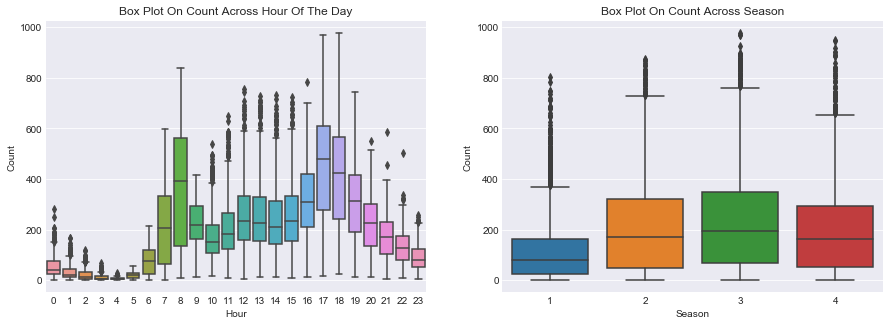

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(15, 5)
sns.boxplot(data=train,y="count",x="hour",orient="v", ax=axes[0])
sns.boxplot(data=train ,y="count",x="season",orient="v",ax=axes[1])

axes[0].set(xlabel='Hour', ylabel='Count', title='Box Plot On Count Across Hour Of The Day')
axes[1].set(xlabel='Season', ylabel='Count', title='Box Plot On Count Across Season')

## 工作日和节日

从下面的图可以看出，是否为工作日或是节日，对共享单车的使用量影响并不大。

[Text(0,0.5,'Count'),
 Text(0.5,0,'Holiday'),
 Text(0.5,1,'Box Plot On Count Across Holiday')]

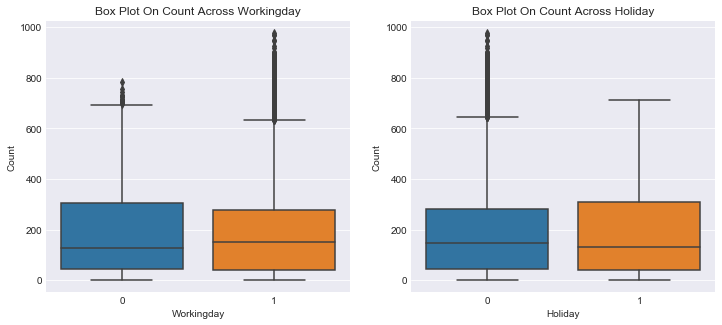

In [6]:
fig, axes4 = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(12, 5)
sns.boxplot(data=train, y='count', x='workingday', ax=axes4[0])
sns.boxplot(data=train, y='count', x='holiday',  ax=axes4[1])
axes4[0].set(xlabel='Workingday', ylabel='Count', title='Box Plot On Count Across Workingday')
axes4[1].set(xlabel='Holiday', ylabel='Count', title='Box Plot On Count Across Holiday')

## 气温和相对湿度

从温度上来看，随着温度的上升，共享单车使用量也增加.

随着湿度的降低，共享单车的使用量也减少了。

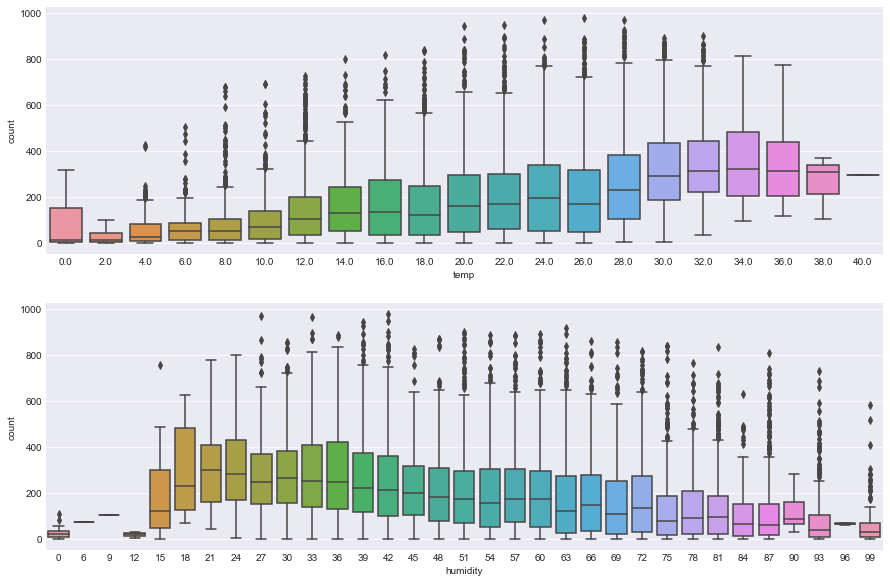

In [7]:
fig, axes2 = plt.subplots(nrows=2, ncols=1)
fig.set_size_inches(15, 10)
sns.boxplot(data=train, y='count', x=train.temp // 2 * 2, ax=axes2[0])
sns.boxplot(data=train, y='count', x=train.humidity // 3 * 3, ax=axes2[1])

## 天气和风速

大体来说，随着天气变坏，共享单车的使用量变小了。对于大雨或暴雪天气，由于记录太少，结果并没有什么参考性。

风速对于使用量的影响不大。

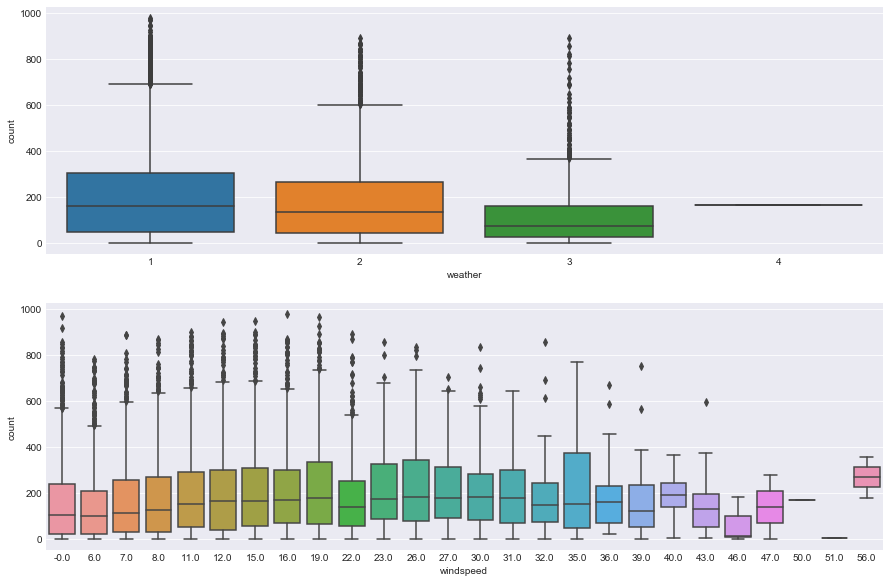

In [8]:
fig, axes3 = plt.subplots(nrows=2, ncols=1)
fig.set_size_inches(15, 10)
sns.boxplot(data=train, y='count', x='weather', ax=axes3[0])
sns.boxplot(data=train, y='count', x=train.windspeed // 1, ax=axes3[1])

## 相关分析

通过相关分析可以发现：
* temp（温度）和atemp（体感温度）高度相关，可以直接舍弃其中一个。
* windspped（风速）和count的相关不明显，说明其对结果的预测作用不大。

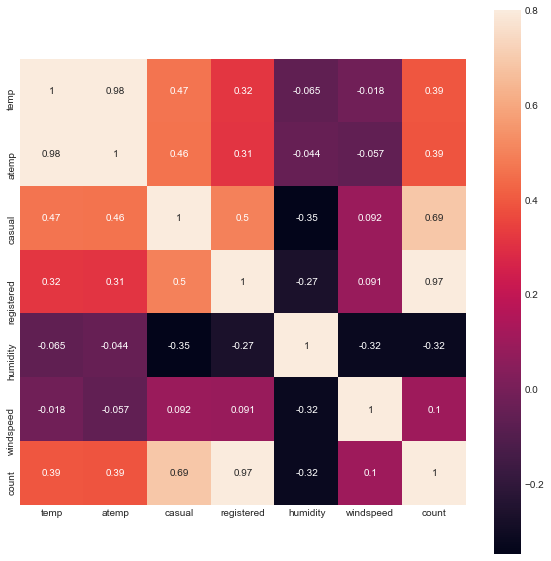

In [9]:
fig, axes = plt.subplots()
fig.set_size_inches(10, 10)
sns.heatmap(train[['temp', 'atemp', 'casual', 'registered', 'humidity', 'windspeed', 'count']].corr(),\
           vmax=.8, square=True, annot=True)

## 分布

由于租用数量的分布为右偏态，所以需要通过log转换来使其更接近正态分布。通过Q-Q图也可以看出，log转化之后更加接近正态分布。

((array([-3.83154229, -3.60754977, -3.48462983, ...,  3.48462983,
          3.60754977,  3.83154229]),
  array([0.        , 0.        , 0.        , ..., 6.87523209, 6.87729607,
         6.88448665])),
 (1.4251967988522145, 4.552561095177975, 0.9568495659313445))

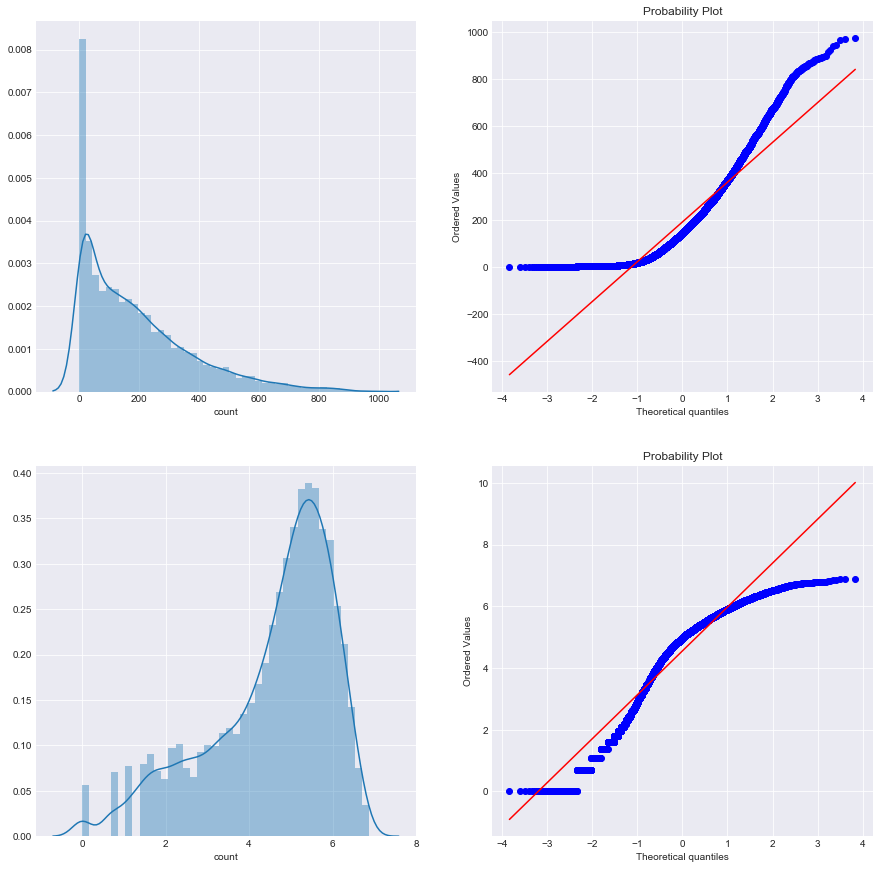

In [10]:
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(15, 15)
sns.distplot(train['count'], ax=axes[0][0])
stats.probplot(train['count'],dist='norm', fit=True, plot=axes[0][1])
sns.distplot(np.log(train['count']), ax=axes[1][0])
stats.probplot(np.log(train['count']), dist='norm', fit=True, plot=axes[1][1])

## 时间的具体分析

下面的分析完全是参考自[kaggle](https://www.kaggle.com/viveksrinivasan/eda-ensemble-model-top-10-percentile/notebook)

从这里可以学到，对于时间序列的分析，需要把日期和时间转化为月份，星期以及时间点来具体分析。在本例中把月份、星期、季节等和时间进行交叉分析，得出了一些很有趣的结论。比如在工作日由于通勤会存在使用高峰，而周末则不存在。以及注册存在明显的通勤高峰，而非注册用户则不存在。

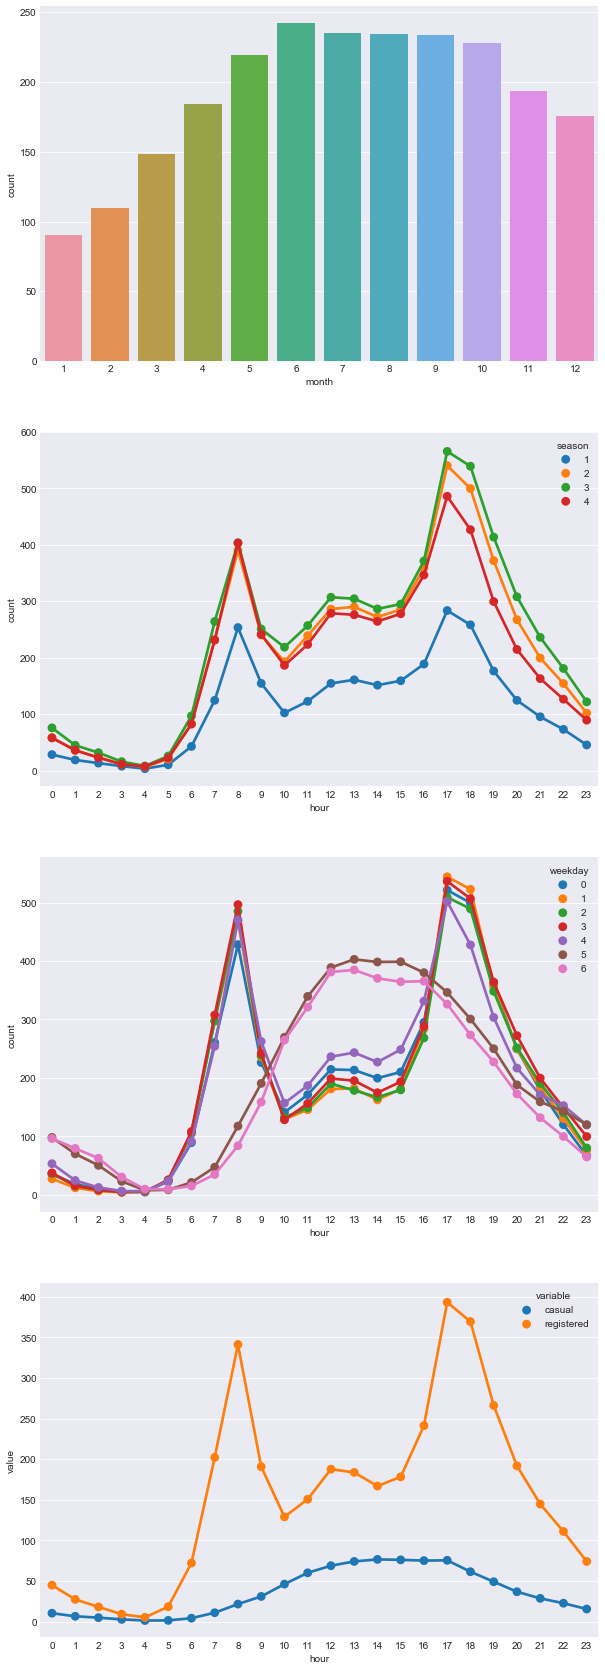

In [11]:
#train['month'] = train['datetime'].apply(lambda x: x.month)

sns.set_style('darkgrid')
fig, axes = plt.subplots(nrows=4)
fig.set_size_inches(10, 30)

monthAggregated = train.groupby('month')['count'].mean().reset_index()
sns.barplot(data=monthAggregated, y='count', x='month', ax=axes[0])

seasonAggregated = train.groupby(['hour', 'season'])['count'].mean().reset_index()
sns.pointplot(data=seasonAggregated, y='count', x='hour', hue='season',\
              join=True, ax=axes[1])

weekdayAggregated = train.groupby(['hour', 'weekday'])['count'].mean().reset_index()
sns.pointplot(data=weekdayAggregated, y='count', x='hour', hue='weekday',\
              join=True, ax=axes[2])

registerAggregated = pd.melt(train[['hour', 'casual', 'registered']], id_vars='hour',\
        value_vars=['casual', 'registered'])
registerAggregated = registerAggregated.groupby(['variable', 'hour'])['value'].mean().reset_index()
sns.pointplot(data=registerAggregated, y='value', x='hour', hue='variable',\
             ax=axes[3])


# 随机森林

下面是对结果的预测部分，使用的随机森林算法。在开始之前，先对数据进行特征工程。

在预测是，对于注册用户和未注册用户分别进行预测，然后相加作为总的结果。同时训练模型之前，先对标签值进行了对数转换，是其更加接近正态分布。这两步对预测结果的准确率都有明显的提升。

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

## 特征工程

In [13]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [14]:
#合并训练集与测试集，以便统一处理
test['registered'] = 0
test['casual'] = 0
test['count'] = 0
data = train.append(test)

### 提取时间
从给出的datetime特征中分离出时间、星期、年这个几个特征

In [15]:
data.datetime = pd.to_datetime(data.datetime)

In [16]:
data['day'] = data.datetime.apply(lambda x: x.weekday())
data['year'] = data.datetime.apply(lambda x: x.year)
#data['month'] = data['datetime'].apply(lambda x: x.month)
data['hour'] = data.datetime.apply(lambda x: x.hour)

### 数据分箱
通过将连续的特征离散化到几个区间内，来提高预测的准确率。

采用的是有监督分箱，先用决策树算法在只是用目标特征的情况下来预测结果。决策树的划分阈值，就是分箱的阈值。在这个项目中，对hour进行分箱处理后，对预测结果有很大的提升。

此方法参考自[这篇文章](https://www.analyticsvidhya.com/blog/2015/06/solution-kaggle-competition-bike-sharing-demand/)

#### binning hour

对hour进行分箱后，预测准确率提升明显。

In [17]:
train = data[data.datetime.apply(lambda x: x.day) < 20]
test = data[data.datetime.apply(lambda x: x.day) > 19]

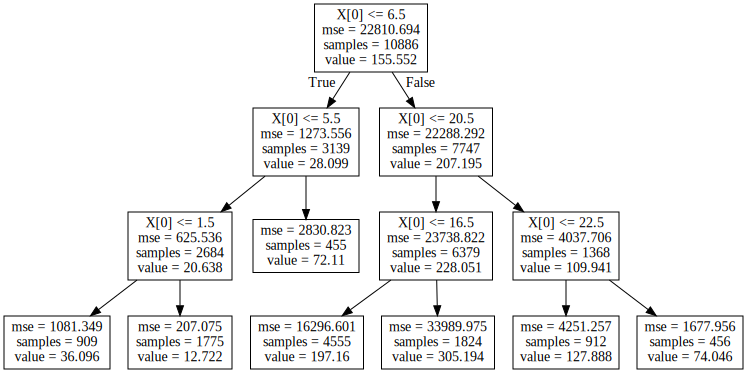

In [18]:
import graphviz
from sklearn import tree
dtr = tree.DecisionTreeRegressor(max_depth=3)
dtr.fit(X=train[['hour']], y=train['registered'])
graphviz.Source(tree.export_graphviz(dtr, out_file=None))

In [19]:
data['dp_reg'] = 0
data.loc[data['hour'].astype('int') <= 1.5, 'dp_reg'] = 1
data.loc[(data['hour'].astype('int') > 1.5) & (data['hour'].astype('int') <= 5.5) , 'dp_reg'] = 2
data.loc[(data['hour'].astype('int') > 5.5) & (data['hour'].astype('int') <= 6.5) , 'dp_reg'] = 3
data.loc[(data['hour'].astype('int') > 6.5) & (data['hour'].astype('int') <= 16.5) , 'dp_reg'] = 4
data.loc[(data['hour'].astype('int') > 16.5) & (data['hour'].astype('int') <= 20.5) , 'dp_reg'] = 5
data.loc[(data['hour'].astype('int') > 20.5) & (data['hour'].astype('int') <= 22.5) , 'dp_reg'] = 6
data.loc[data['hour'].astype('int') > 22.5, 'dp_reg'] = 7

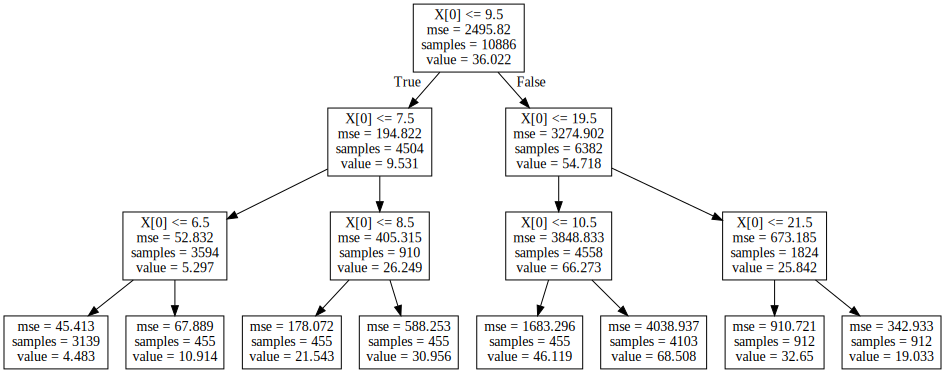

In [20]:
from sklearn import tree
dtr = tree.DecisionTreeRegressor(max_depth=3)
dtr.fit(X=train[['hour']], y=train['casual'])
graphviz.Source(tree.export_graphviz(dtr, out_file=None))

In [21]:
data['dp_cas'] = 0
data['hour'] = data['hour'].astype('int')
data.loc[data['hour'] <= 6.5, 'dp_cas'] = 1
data.loc[(data['hour'] > 6.5) & (data['hour'] <= 7.5), 'dp_cas'] = 2
data.loc[(data['hour'] > 7.5) & (data['hour'] <= 8.5), 'dp_cas'] = 3
data.loc[(data['hour'] > 8.5) & (data['hour'] <= 9.5), 'dp_cas'] = 4
data.loc[(data['hour'] > 9.5) & (data['hour'] <= 10.5), 'dp_cas'] = 5
data.loc[(data['hour'] > 10.5) & (data['hour'] <= 19.5), 'dp_cas'] = 6
data.loc[(data['hour'] > 19.5) & (data['hour'] <= 21.5), 'dp_cas'] = 7
data.loc[data['hour'] > 21.5, 'dp_cas'] = 1

#### binning temp

对temp分箱之后，预测结果并没有什么明显提升

In [22]:
data['temp_reg'] = 0
data.loc[data['temp'] < 13, 'temp_reg'] = 1
data.loc[(data['temp'] >= 13) & (data['temp'] < 23), 'temp_reg'] = 2
data.loc[(data['temp'] >= 23) & (data['temp'] < 30), 'temp_reg'] = 3
data.loc[(data['temp'] >= 30), 'temp_reg'] = 4

In [23]:
data['temp_cas'] = 0
data.loc[data['temp'] < 15, 'temp_cas'] = 1
data.loc[(data['temp'] >= 15) & (data['temp'] < 23), 'temp_cas'] = 2
data.loc[(data['temp'] >= 23) & (data['temp'] < 30), 'temp_cas'] = 3
data.loc[(data['temp'] >= 30), 'temp_cas'] = 4

### 预测风速的缺失值

风速数据虽然看起来没有缺失，但是深入观察之后可以发现，当风速值为0日，即代表风速数据缺失。因为风速为0的频率异常的高。

可以通过季节、天气、湿度、湿度等特征来预测风速的缺失值。但是填充之后对预测结果并没有什么提升。

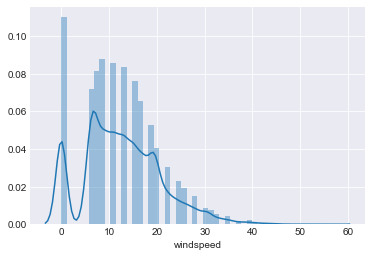

In [24]:
sns.distplot(data['windspeed'])

In [25]:
#处理风速
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=200, n_jobs=-1)
windPreCol = ['season','weather', 'humidity', 'temp', 'year', 'atemp']
wind0 = data[data['windspeed'] == 0].copy()
wind1 = data[data['windspeed'] !=0].copy()
rf.fit(wind1[windPreCol], wind1['windspeed'])

wind0['windspeed'] = rf.predict(wind0[windPreCol])
data = wind1.append(wind0)

In [26]:
#将下列特征转换为离散变量
categoryCol = ['season','holiday', 'workingday', 'weather', 'hour', 
              'dp_cas', 'dp_reg', 'day', 'temp_cas', 'temp_reg']

for col in categoryCol:
    data[col] = data[col].astype('category')

## Feature Importance

查看在随机森林模型中，各特征的重要性。

可以看出，最重要的特征是dp_cas，也就是我们根据data binning构造出来的特征。其次是hour和year

In [27]:
train = data[data.datetime.apply(lambda x: x.day) < 20]
rf.fit(train.drop(['count', 'casual', 'registered', 'datetime'],axis=1), train['count'])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [28]:
importance = rf.feature_importances_
feature = train.drop(['count', 'casual', 'registered', 'datetime'],axis=1).columns
feature_imp = pd.DataFrame({'importance':importance}, index=feature)

In [29]:
feature_imp.sort_values('importance', ascending=False)

,importance
dp_cas,0.431237
hour,0.160408
year,0.094557
temp,0.069006
season,0.045509
workingday,0.043123
day,0.040188
atemp,0.033623
humidity,0.029983
dp_reg,0.020112


## 预测结果

In [35]:
#预测并保存结果

train = data[data.datetime.apply(lambda x: x.day) < 20]
test = data[data.datetime.apply(lambda x: x.day) > 19]
rf = RandomForestRegressor(n_estimators=250, n_jobs=-1)

#未注册用户
X_cas = train.drop(['count', 'casual', 
            'registered', 'datetime'],axis=1)
#log转换
y_cas = np.log1p(train['casual'])
rf.fit(X = X_cas, y=y_cas)

pred_casual = rf.predict(test.drop(['count', 'casual', 
            'registered', 'datetime'],axis=1))


#已注册用户
X_reg = train.drop(['count', 'casual', 
            'registered', 'datetime'],axis=1)
#log转换
y_reg = np.log1p(train['registered'])
rf.fit(X = X_reg, y=y_reg)
pred_registered = rf.predict(test.drop(['count', 'casual', 
            'registered', 'datetime'],axis=1))

#合并预测结果，还原log转换后的结果
pred_all = (np.exp(pred_casual) - 1) + (np.exp(pred_registered) - 1)

#保存结果
saveResults(pred_all,test, 'submit.csv')

submit.csv已保存到本地


## 工具函数
这是一些我在探索分析过程中多次用到的一些操作，为了保持结果的逻辑清晰，中间很多探索性的部分我都删去了，所以有些工具函数在上面并没有出现。

In [31]:
#分别计算已注册和未注册用户的分数
def reg_cas_score(data):
    train = data[data.datetime.apply(lambda x: x.day) < 20]
    test = data[data.datetime.apply(lambda x: x.day) > 19]
    reg_score = cross_val_score(X = train.drop(['count', 'casual', 'registered', 'datetime'],
                             axis=1), y=train['registered'], estimator=rf, 
               scoring=rmsle_scoring2).mean()
    cas_score = cross_val_score(X = train.drop(['count', 'casual', 'registered', 'datetime'],
                             axis=1), y=train['casual'], estimator=rf, 
               scoring=rmsle_scoring2).mean()
    print('reg_score = ' + str(reg_score) + '\ncas_score = ' + str(cas_score))

In [32]:
#保存文件到本地
def saveResults(pre, test, fileName):
    submit = test[['datetime', 'count']].copy()
    submit['count'] = pre
    submit.to_csv(fileName, index=False)
    print(fileName  + '已保存到本地')

In [33]:
#比赛要求评价方法rmsle的实现,来自 https://www.kaggle.com/marknagelberg/rmsle-function
from sklearn.metrics import make_scorer
def rmsle_exp2(y_pred, y_test) : 
    assert len(y_test) == len(y_pred)
    #由于前面对结果进行了log化，在这里对结果进行还原
    #y_pred = np.exp(y_pred) -1
    #y_test = np.exp(y_test) -1
    return np.sqrt(np.mean((np.log(1+y_pred) - np.log(1+y_test))**2))

rmsle_scoring2 = make_scorer(rmsle_exp2, greater_is_better=False)

# 总结

这个项目的重点在于需要从已有的特征中提取出新的特征，比如hour,year。对于和时间相关的特征，提取新特征应该是必须要做的步骤。但在提取新特征的时候，也发现了一些问题，当我增加month这个特征之后，预测结果非常明显的变差了。按理来说，冗余特征对随机森林应该不会产生什么影响才对。我在网上找了一圈也没有找到相关的资料和问题，这个问题还有待结果。

要注意标签值，也就是要预测的目标值是否为正态分布，如果不是，需要将其转换为正态分布，可以使用对数转换。转换之后预测结果会有明显提升。

可以把结果分成几个部分来分别预测，在这个项目中，通过分别预测已注册用户和未注册用户，再合成为最终结果，使预测准确率明显的提升。

本来是打算再使用stacking法融合多个模型来进一步提高准确率，但是照搬了以前的代码后发现结果反而变差了，找了好久也没找到问题出在哪，等以后时间了再加上去吧。